In [11]:
import matplotlib.pyplot as plt, numpy as np 
import json

lang_prefix = ["eng", "ddo", "lez", "git", "ntu"]
prefix_dict = {"eng":"English", "ddo":"Tsez", "git": "Gitksan", "lez": "Lezgi", "ntu": "Natugu"}

#Function to extract f_scores from output JSON files
def extract_fscores(model_type, scores_dict, output_data):
        i = 0 
        for item in output_data:
            if model_type in item["model"]:
                parts = item["model"].split("_")
                for part in parts:
                    if part.isdigit():
                        i = int(part) 
                        scores_dict[i] = float(item["f_measure"])

#Function to plot vocab_size vs. f_score plots for BPE and ULM
def spm_plot(fscores_bpe, fscores_ulm, title_fill):
    x = list(fscores_bpe.keys())
    y1 = list(fscores_bpe.values())
    y2 = list(fscores_ulm.values())
    fig, ax = plt.subplots()
    ax.set_xlabel('vocab_size')
    ax.set_ylabel('f_measure')
    ax.set_title(f'BPE and ULM performance for different vocab_size ({title_fill})')
    ax.scatter(x, y1, label='BPE')
    ax.scatter(x, y2, label='ULM')
    ax.legend()

#Function to plot --morph-length vs f_score plots or --num-morph-types vs. f_score plots for Morfessor
def morfessor_plot(fscores_morfessor, title_fill, type):
    a = list(fscores_morfessor.keys())
    b = list(fscores_morfessor.values())
    if type == "morph_length":
         xlabel = "Morph Length"
         title = f"Morfessor performance for different --morph-length values ({title_fill})"
    elif type == "num_morph_types":
         xlabel = "Number of morpheme types"
         title = f"Morfessor performance for different --num-morph-types values ({title_fill})"
    fig, ax = plt.subplots()
    ax.set_xlabel(xlabel)
    ax.set_ylabel('f_measure')
    ax.set_title(title)
    if type == "morph_length":
        ax.bar(a,b)
    elif type == "num_morph_types":
        ax.scatter(a, b)

## Plotting how vocab_size affects the f_measure for BPE and ULM

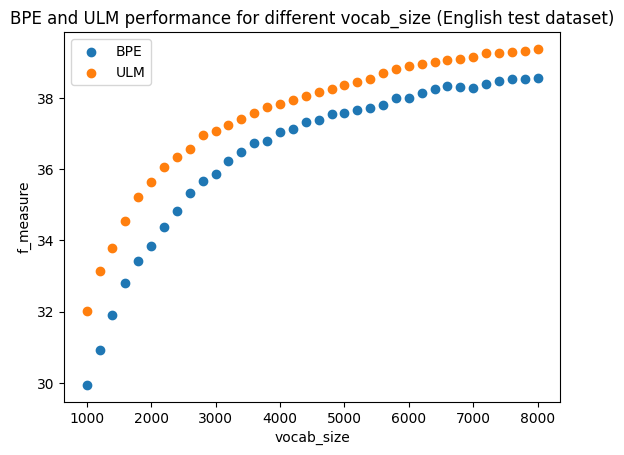

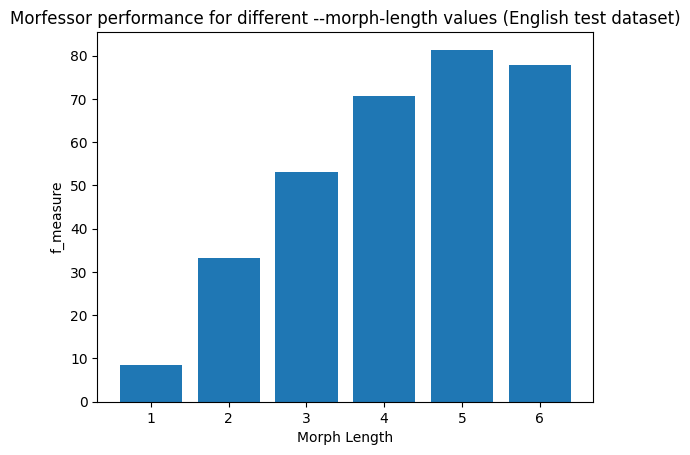

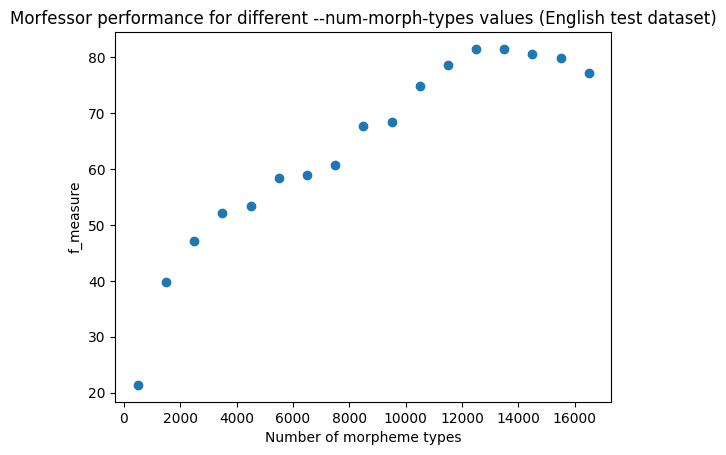

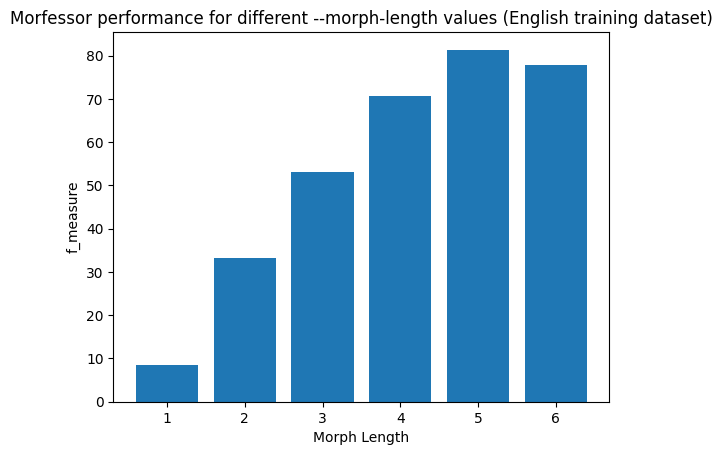

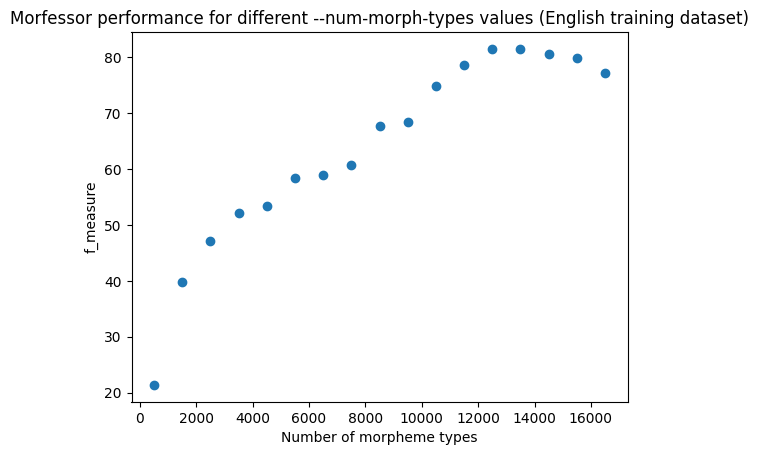

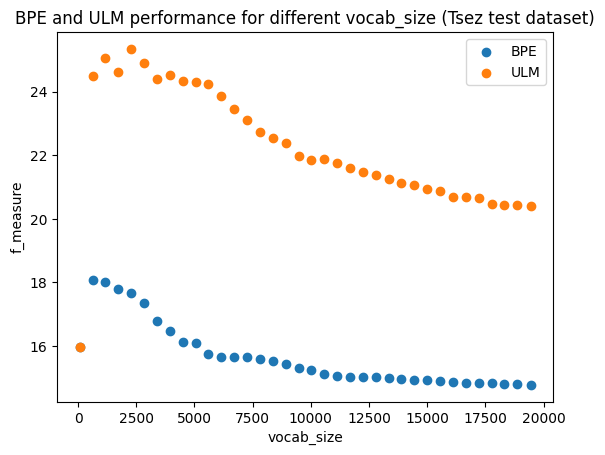

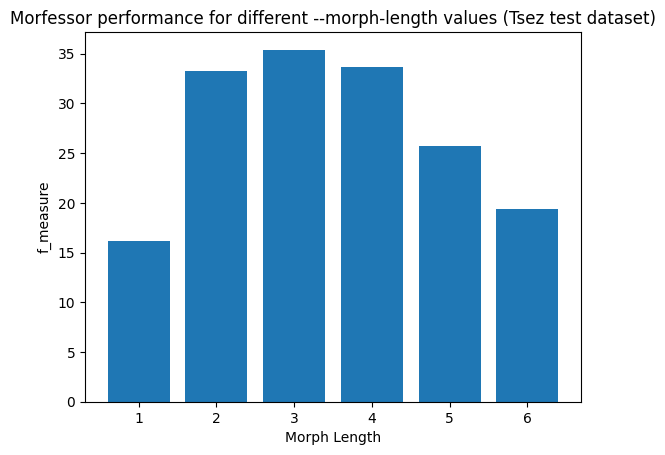

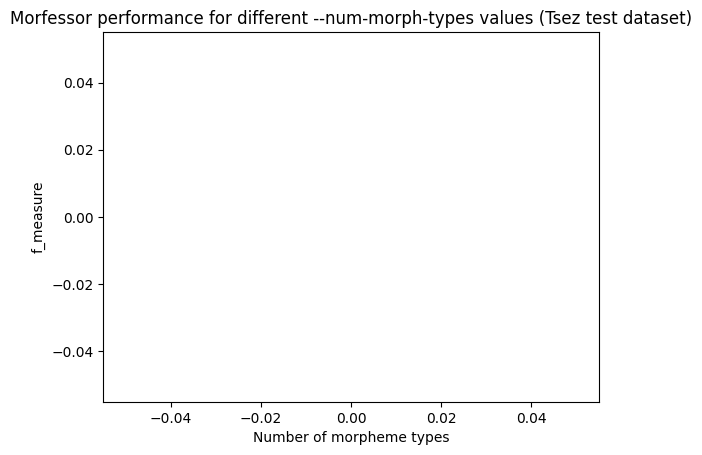

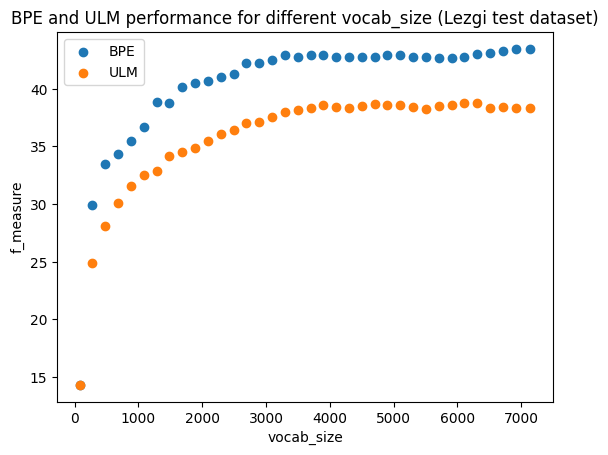

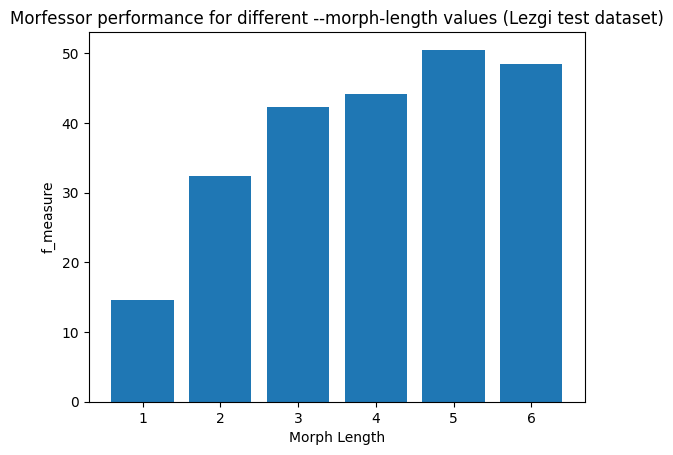

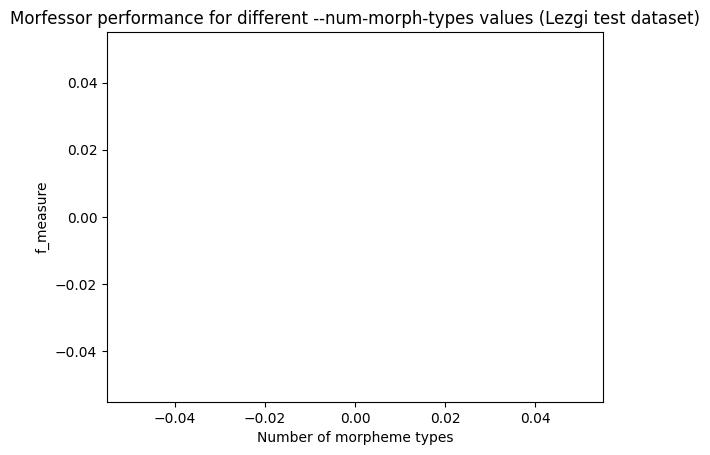

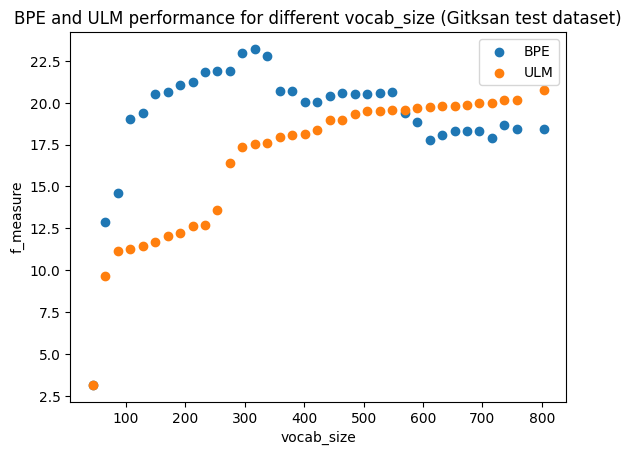

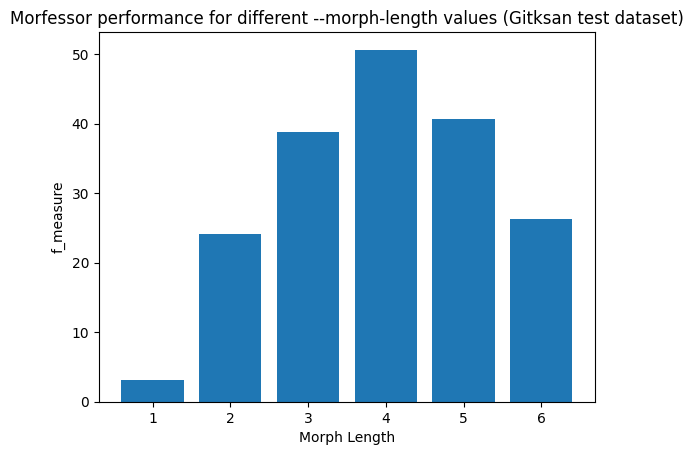

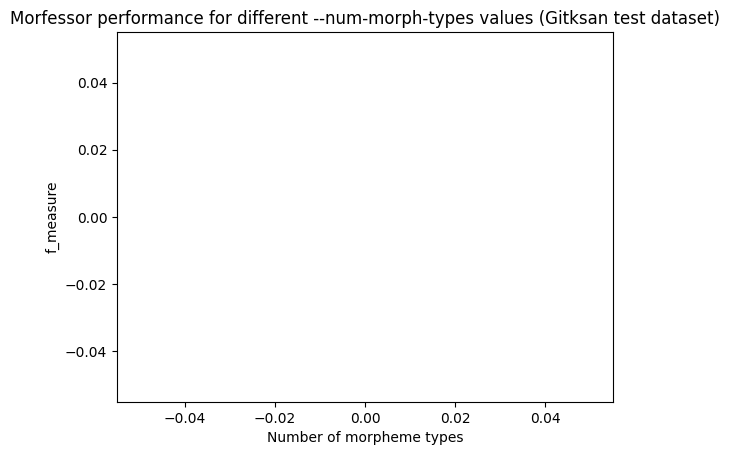

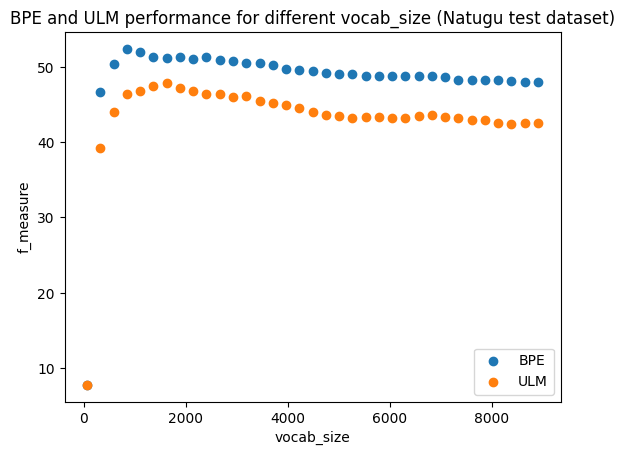

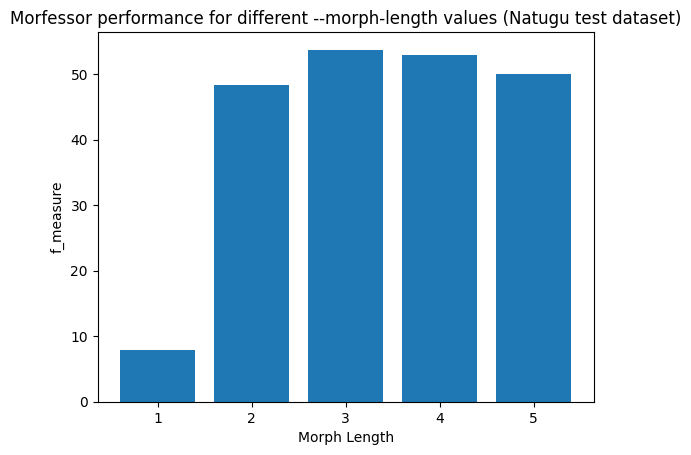

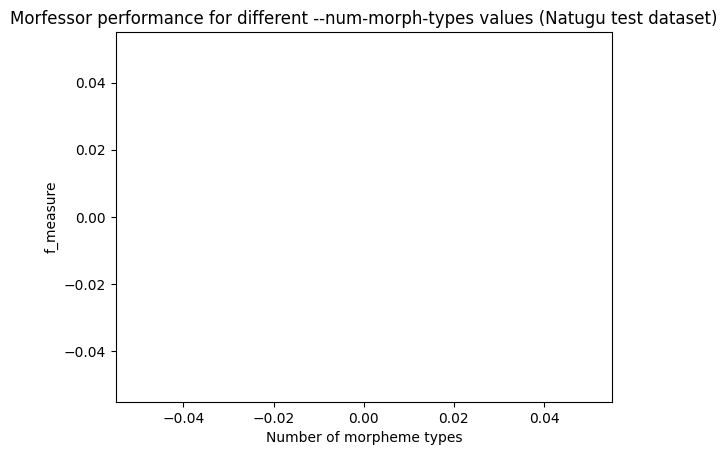

In [12]:

for lang in lang_prefix: 
    output_file = f"outputs\\{lang}.output.json"
    with open(output_file, 'r') as f:
        output_dict = json.load(f)

    output_data = output_dict["data"]
    fscores_bpe = {}
    fscores_ulm = {}
    fscores_morfessor_len = {}
    fscores_morfessor_types = {}
    fscores_morfessor_training_len = {}
    fscores_morfessor_training_types = {}

    extract_fscores("bpe", fscores_bpe, output_data=output_data)
    extract_fscores("ulm", fscores_ulm, output_data=output_data)
    extract_fscores("morfessor_len", fscores_morfessor_len, output_data=output_data)
    extract_fscores("morfessor_types", fscores_morfessor_types, output_data=output_data)
    
    spm_plot(fscores_bpe=fscores_bpe, fscores_ulm=fscores_ulm, title_fill=f"{prefix_dict[lang]} test dataset")
    morfessor_plot(fscores_morfessor=fscores_morfessor_len, title_fill=f"{prefix_dict[lang]} test dataset", type="morph_length")
    morfessor_plot(fscores_morfessor=fscores_morfessor_types, title_fill=f"{prefix_dict[lang]} test dataset", type="num_morph_types")

    if lang == "eng":
        extract_fscores("morfessor_training_len", fscores_morfessor_training_len, output_data=output_data)
        extract_fscores("morfessor_training_types", fscores_morfessor_training_types, output_data=output_data)
        morfessor_plot(fscores_morfessor=fscores_morfessor_len, title_fill=f"{prefix_dict[lang]} training dataset", type="morph_length")
        morfessor_plot(fscores_morfessor=fscores_morfessor_types, title_fill=f"{prefix_dict[lang]} training dataset", type="num_morph_types")

## Plotting how --morph-length affects the f_measure for Morfessor 

## Plotting how --num-morph-types affects the f_measure for Morfessor 